<a href="https://colab.research.google.com/github/AugustasJar/MD_RADAR_ML/blob/main/radar_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.optim.lr_scheduler import CosineAnnealingLR # Import the scheduler

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

In [ ]:


class PositionalEncoding(nn.Module):
    """
    Standard sinusoidal Positional Encoding.
    Adapted from PyTorch tutorials.
    """
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # positional encoding
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        # constants for generating positional encoding
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0) # Shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, d_model]
        """
        # x.size(1) is the sequence length
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self, input_channels, num_classes, d_model=128, nhead=4, num_encoder_layers=2,
                 dim_feedforward_transformer=256, conv_kernel_size=3, dropout=0.1, seq_len_after_conv=None):
        super(TransformerModel, self).__init__()

        self.d_model = d_model

        # We'll use 1D convolutions. Assuming padding to maintain sequence length for simplicity.
        # If seq_len_after_conv is not specified, we assume convs preserve length.
        padding = (conv_kernel_size - 1) // 2

        self.conv1 = nn.Conv1d(input_channels, d_model // 2, kernel_size=conv_kernel_size, padding=padding)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(d_model // 2, d_model, kernel_size=conv_kernel_size, padding=padding)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv1d(d_model, d_model, kernel_size=conv_kernel_size, padding=padding)
        self.relu3 = nn.ReLU()

        # Combined convolutional block
        self.conv_block = nn.Sequential(
            self.conv1, self.relu1,
            self.conv2, self.relu2,
            self.conv3, self.relu3
        )

        # 2. Positional Encoding
        # positional encoding, the max_length should be adjusted to what it becomes after convolution.
        _max_len = seq_len_after_conv if seq_len_after_conv is not None else 512 # Default max_len for PE
        self.positional_encoding = PositionalEncoding(d_model, dropout, max_len=_max_len)

        # 3. Transformer Encoder (2x)
        # batch_first=True expects input as (batch_size, seq_len, features)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward_transformer,
            dropout=dropout,
            batch_first=True  # Crucial for (batch, seq, feature) input
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_encoder_layers
        )

        # 4. Feed Forward Network (for classification)
        self.final_ffn = nn.Linear(d_model, num_classes)

    def forward(self, src):
        """
        Args:
            src: Input tensor, shape [batch_size, input_channels, sequence_length]
        """
        # 1. Convolutional Layers
        # Input: (batch_size, input_channels, sequence_length)
        # Output: (batch_size, d_model, sequence_length_after_conv)
        conv_out = self.conv_block(src)

        # Permute for Positional Encoding and Transformer: (batch_size, sequence_length, d_model)
        x = conv_out.permute(0, 2, 1)

        # 2. Add Positional Encoding
        x = self.positional_encoding(x)

        # 3. Transformer Encoder
        # Input: (batch_size, sequence_length, d_model)
        # Output: (batch_size, sequence_length, d_model)
        transformer_out = self.transformer_encoder(x)

        # Aggregate Transformer output
        # Output: (batch_size, d_model)
        aggregated_out = transformer_out.mean(dim=1) # Mean pooling across, other methods may be tested

        # 4. Final Feed Forward Network
        # Output: (batch_size, num_classes)
        output = self.final_ffn(aggregated_out)

        return output


In [ ]:
import pandas as pd
# read csv. The output should be (N_samples, total_features)
df = pd.read_csv("radar_features_output_n20.csv")
df.shape

(1754, 162)

In [ ]:
# convert to numpy for processing
radar_data = np.array(df)
# shuffle the rows (useful because we split the dataset into train and validation)
np.random.shuffle(radar_data)
total_features = radar_data.shape[1]
print(total_features)
#exclude first column, because its just the sample number.
#second column is the name of the sample, which encodes the activity
names = radar_data[:,1]
x_dat = radar_data[:,2:total_features] # ignore indices and names

162
189


In [ ]:
#IMPORTANT, check whether the data contains NaN values,
#if it does the training will fail or give unexecpected results
x_dat = np.nan_to_num(x_dat, nan=0.0);
nan_indices = np.isnan(x_dat.astype(np.float32).any())
print("Indices with NaN values:",nan_indices)
print(x_dat.shape)


Indices with NaN values: False
(1754, 400)


In [ ]:
#Decode the activities to integers from file names
y = []
for file_name in names:
    # Get the first character and convert it to an integer
    integer = int(file_name[0])-1
    y.append(integer)

# Convert the list of labels to a numpy array if needed
y_dat = np.array(y)

print("Original y (first 10 elements):", names[:10])
print("Generated labels (first 10 elements):", y[:10])
print("nan values",np.isnan(y_dat).any())

Original y (first 10 elements): ['2P03A02R2.dat' '1P13A01R02.dat' '3P33A03R2.dat' '6P63A06R2.dat'
 '1P52A01R01.dat' '2P07A02R02.dat' '2P67A02R3.dat' '3P22A03R1.dat'
 '1P19A01R2.dat' '4P52A04R3.dat']
Generated labels (first 10 elements): [1, 0, 2, 5, 0, 1, 1, 2, 0, 3]
nan values False


In [ ]:
num_samples,num_features = radar_data.shape
#the first two collumns - indices and file names - are not features
num_features = num_features-2
num_classes = len(np.unique(y_dat))
print("Num_classes",num_classes)

Num_classes 6


In [ ]:
train_split = 0.85
# val_split = 0.2
#split the data set
train_data = x_dat[:int(train_split*num_samples)].astype(np.float32)
train_labels = y_dat[:int(train_split*num_samples)]

train_data = np.nan_to_num(train_data, nan=0.0);
val_data = x_dat[int(train_split*num_samples):]
val_labels = y_dat[int(train_split*num_samples):]


#Recheck for NaNs!!!
print("nan values",np.isnan(train_data).any())

nan values False


In [ ]:
input_channels = 8  # amount of features per time instant
sequence_length = 50 # Amount of chunks the time series is split into
num_classes = num_classes #  number of output classes

# as specified in the model, the input is (batch_size, input channels, sequence length)
train_data = train_data.reshape((-1,input_channels,sequence_length))
val_data = val_data.reshape((-1,input_channels,sequence_length))
print(train_data.shape)

(1490, 8, 50)


In [ ]:
#actually questionable gains from normalization from my testing.

N,M,L = train_data.shape
print(N,M,L)
# normalize feature vector at every time instance.
for i in range(N):
    for j in range(M):
        train_data[i,j,:] = (train_data[i,j,:] - np.mean(train_data[i,j,:])) / np.std(train_data[i,j,:])

N,M,L = val_data.shape
print(N,M,L)
# normalize feature vector at every time instance.
for i in range(N):
    for j in range(M):
        val_data[i,j,:] = (val_data[i,j,:] - np.mean(val_data[i,j,:])) / np.std(val_data[i,j,:])

1490 8 50
264 8 50


In [ ]:
from torch.utils.data import Dataset, DataLoader
#initialise a dataset class
class CustomRadarDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [ ]:
#upload the data to device, which allows training on the GPU
x = torch.tensor(train_data.astype(np.float32), dtype=torch.float32)
y = torch.tensor(train_labels, dtype=torch.long)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

x_val = torch.tensor(val_data.astype(np.float32), dtype=torch.float32)
y_val = torch.tensor(val_labels, dtype=torch.long)

train_dataset = CustomRadarDataset(x, y)
val_dataset = CustomRadarDataset(x_val, y_val)




In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

#Train loop

def train_with_dataloader(model, train_dataloader, val_dataloader,scheduler,
                          criterion, optimizer, num_epochs, device,training_threshold=4e-4):
    model.to(device)  # Move the model to the specified device (CPU or GPU)
    model.train()  # Set the model to training mode
    train_losses = []  # To store loss per epoch
    val_accuracies = [] # To store validation accuracy per epoch
    for epoch in range(num_epochs):
        total_loss = 0

        # Iterate over the training data using the DataLoader
        for batch_features, batch_labels in train_dataloader:
            # check if there are any invalid datapoints
            if (torch.isnan(batch_features).any()):
                print("nan values in batch")
                break;
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)

            optimizer.zero_grad()  # Zero the gradients
            out = model(batch_features) # Forward pass
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            loss = criterion(out, batch_labels) # Calculate loss
            loss.backward()        # Backpropagation
            optimizer.step()       # Update weights


            total_loss += loss.item()
        #update the scheduler
        scheduler.step()
        avg_train_loss = total_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        # Evaluate on the validation set
        val_acc = evaluate_with_dataloader(model, val_dataloader, device)
        val_accuracies.append(val_acc)
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Validation Accuracy: {val_acc:.2f}%, LR: {current_lr:.6f}')
        if avg_train_loss <= training_threshold:
            print("breaking due to loss gelow threshold")
            break
    return train_losses, val_accuracies

def evaluate_with_dataloader(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad(): # Disable gradient calculation for evaluation
        for batch_features, batch_labels in dataloader:
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)

            outputs = model(batch_features)
            _, predicted = torch.max(outputs.data, 1) # Get the predicted class
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy


In [ ]:
batch_size = 128
d_model = 256    # Embedding dimension (must be divisible by nhead)
nhead = 16        # Number of heads in multi-head attention
num_encoder_layers = 2
dim_feedforward_transformer = 256 # Dim of FFN in TransformerEncoderLayer
conv_kernel_size = 3
dropout = 0.1
num_epochs = 100
learning_rate = 0.0005
gamma = 0.98

In [ ]:
samples_per_epoch = x_dat.shape[0]
print(samples_per_epoch)

1754


In [ ]:
from torch.optim.lr_scheduler import ExponentialLR

print(device)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = TransformerModel(
      input_channels=input_channels,
      num_classes=num_classes,
      d_model=d_model,
      nhead=nhead,
      num_encoder_layers=num_encoder_layers,
      dim_feedforward_transformer=dim_feedforward_transformer,
      conv_kernel_size=conv_kernel_size,
      dropout=dropout,
      seq_len_after_conv=sequence_length # Pass the expected seq len after convs
)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
#for Decaying learning rate we use a scheduler.
scheduler = ExponentialLR(optimizer, gamma=gamma)
criterion = nn.CrossEntropyLoss()


cuda


In [ ]:
losses, accuracy = train_with_dataloader(model, train_dataloader, val_dataloader, scheduler,
                                         criterion, optimizer, num_epochs, device,training_threshold=4e-4)

Epoch 1/100, Train Loss: 1.8552, Validation Accuracy: 1.89%, LR: 0.000490
Epoch 2/100, Train Loss: 1.4840, Validation Accuracy: 14.39%, LR: 0.000480
Epoch 3/100, Train Loss: 0.9672, Validation Accuracy: 15.15%, LR: 0.000471
Epoch 4/100, Train Loss: 0.7142, Validation Accuracy: 15.91%, LR: 0.000461
Epoch 5/100, Train Loss: 0.5419, Validation Accuracy: 17.42%, LR: 0.000452
Epoch 6/100, Train Loss: 0.4358, Validation Accuracy: 17.80%, LR: 0.000443
Epoch 7/100, Train Loss: 0.3616, Validation Accuracy: 17.80%, LR: 0.000434
Epoch 8/100, Train Loss: 0.3265, Validation Accuracy: 17.80%, LR: 0.000425
Epoch 9/100, Train Loss: 0.2709, Validation Accuracy: 18.18%, LR: 0.000417
Epoch 10/100, Train Loss: 0.2438, Validation Accuracy: 17.80%, LR: 0.000409
Epoch 11/100, Train Loss: 0.3256, Validation Accuracy: 17.05%, LR: 0.000400
Epoch 12/100, Train Loss: 0.2521, Validation Accuracy: 17.42%, LR: 0.000392
Epoch 13/100, Train Loss: 0.1959, Validation Accuracy: 18.18%, LR: 0.000385
Epoch 14/100, Train Lo

KeyboardInterrupt: 

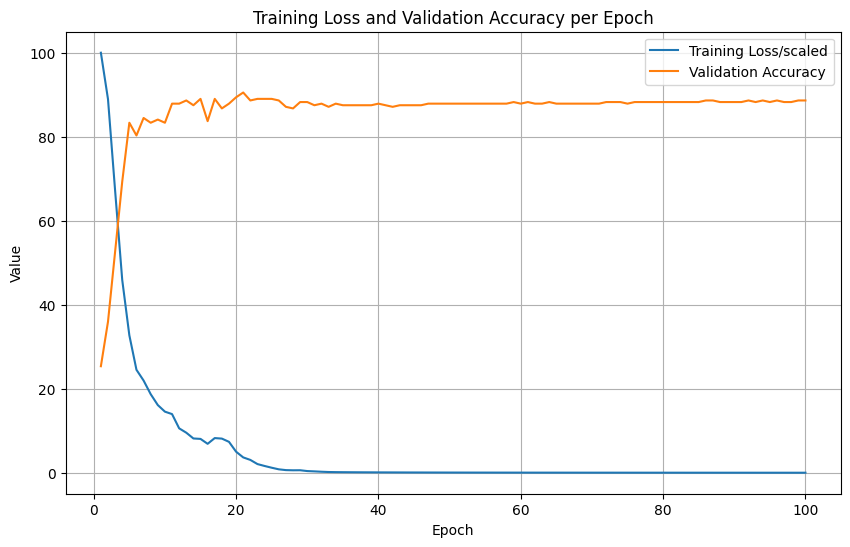

max validation accuracy: 90.53%


In [ ]:

import matplotlib.pyplot as plt

epochs = len(losses)
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), [l * 100/max(losses) for l in losses], label='Training Loss/scaled')
plt.plot(range(1, epochs + 1), accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Loss and Validation Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()

print(f"max validation accuracy: {max(accuracy):.2f}%")

In [ ]:
# GRID SEARCH
import itertools
# Define the parameter grid
param_grid = {
    'd_model': [128, 256, 384],
    'nhead': [4, 8, 16],
    'num_encoder_layers': [1, 2, 3],
    'dim_feedforward_transformer': [128, 256, 512],
    'conv_kernel_size': [3, 5],
}

best_accuracy = 0
best_params = {}
results = []
batch_size = 128
# Get all combinations of parameters
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

print(f"Total combinations to test: {len(param_combinations)}")

# Assuming your dataset and device are already defined from the previous cells
# train_dataset, val_dataset, device, input_channels, num_classes, sequence_length

for i, params in enumerate(param_combinations):
    print(f"\n--- Testing combination {i+1}/{len(param_combinations)} ---")
    print(f"Parameters: {params}")

    # Update batch size for dataloaders
    batch_size = batch_size
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Instantiate the model with current parameters
    model = TransformerModel(
          input_channels=input_channels,
          num_classes=num_classes,
          d_model=params['d_model'],
          nhead=params['nhead'],
          num_encoder_layers=params['num_encoder_layers'],
          dim_feedforward_transformer=params['dim_feedforward_transformer'],
          conv_kernel_size=params['conv_kernel_size'],
          dropout=dropout,
          seq_len_after_conv=sequence_length # Pass the expected seq len after convs,
    )

    # Define optimizer and scheduler with current parameters
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = ExponentialLR(optimizer, gamma=gamma)
    criterion = nn.CrossEntropyLoss()

    # Train and evaluate the model
    # You can adjust the number of epochs for the grid search if needed
    # to save computation time, e.g., num_epochs = 20
    num_epochs_grid_search = 50
    train_losses, val_accuracies = train_with_dataloader(
        model, train_dataloader, val_dataloader, scheduler, criterion, optimizer,
          num_epochs_grid_search, device,training_threshold=5e-3
    )

    # Get the best validation accuracy from this run
    current_best_accuracy = max(val_accuracies) if val_accuracies else 0

    # Store results
    results.append({
        'params': params,
        'best_val_accuracy': current_best_accuracy,
        'val_accuracies_per_epoch': val_accuracies, # Optional: store for analysis
        'train_losses_per_epoch': train_losses # Optional: store for analysis
    })

    # Update best parameters if current accuracy is better
    if current_best_accuracy > best_accuracy:
        best_accuracy = current_best_accuracy
        best_params = params
        print(f"New best accuracy: {best_accuracy:.2f}% with parameters: {best_params}")

print("\n--- Grid Search Complete ---")
print(f"Best validation accuracy found: {best_accuracy:.2f}%")
print(f"Best parameters: {best_params}")


Streaming output truncated to the last 5000 lines.
Epoch 29/50, Train Loss: 0.0617, Validation Accuracy: 89.39%, LR: 0.000278
Epoch 30/50, Train Loss: 0.0639, Validation Accuracy: 87.12%, LR: 0.000273
Epoch 31/50, Train Loss: 0.0414, Validation Accuracy: 87.88%, LR: 0.000267
Epoch 32/50, Train Loss: 0.0306, Validation Accuracy: 87.50%, LR: 0.000262
Epoch 33/50, Train Loss: 0.0236, Validation Accuracy: 89.39%, LR: 0.000257
Epoch 34/50, Train Loss: 0.0275, Validation Accuracy: 87.50%, LR: 0.000252
Epoch 35/50, Train Loss: 0.0260, Validation Accuracy: 87.50%, LR: 0.000247
Epoch 36/50, Train Loss: 0.0274, Validation Accuracy: 88.26%, LR: 0.000242
Epoch 37/50, Train Loss: 0.0201, Validation Accuracy: 87.50%, LR: 0.000237
Epoch 38/50, Train Loss: 0.0230, Validation Accuracy: 88.64%, LR: 0.000232
Epoch 39/50, Train Loss: 0.0154, Validation Accuracy: 88.26%, LR: 0.000227
Epoch 40/50, Train Loss: 0.0109, Validation Accuracy: 87.88%, LR: 0.000223
Epoch 41/50, Train Loss: 0.0085, Validation Accur

In [ ]:
# prompt: sort results by accuracy, give top 10 results

# Sort the results by best_val_accuracy in descending order
sorted_results = sorted(results, key=lambda x: x['best_val_accuracy'], reverse=True)

# Print the top 10 results
print("\n--- Top 10 Results by Validation Accuracy ---")
for i, result in enumerate(sorted_results[:10]):
  print(f"Rank {i+1}: Accuracy: {result['best_val_accuracy']:.2f}%, Params: {result['params']}")


--- Top 10 Results by Validation Accuracy ---
Rank 1: Accuracy: 92.05%, Params: {'d_model': 128, 'nhead': 8, 'num_encoder_layers': 2, 'dim_feedforward_transformer': 256, 'conv_kernel_size': 5}
Rank 2: Accuracy: 92.05%, Params: {'d_model': 128, 'nhead': 8, 'num_encoder_layers': 3, 'dim_feedforward_transformer': 256, 'conv_kernel_size': 3}
Rank 3: Accuracy: 92.05%, Params: {'d_model': 256, 'nhead': 8, 'num_encoder_layers': 1, 'dim_feedforward_transformer': 128, 'conv_kernel_size': 3}
Rank 4: Accuracy: 92.05%, Params: {'d_model': 256, 'nhead': 8, 'num_encoder_layers': 2, 'dim_feedforward_transformer': 256, 'conv_kernel_size': 3}
Rank 5: Accuracy: 92.05%, Params: {'d_model': 256, 'nhead': 8, 'num_encoder_layers': 3, 'dim_feedforward_transformer': 128, 'conv_kernel_size': 3}
Rank 6: Accuracy: 91.67%, Params: {'d_model': 128, 'nhead': 4, 'num_encoder_layers': 1, 'dim_feedforward_transformer': 512, 'conv_kernel_size': 5}
Rank 7: Accuracy: 91.67%, Params: {'d_model': 128, 'nhead': 4, 'num_enc

Grid search results:

defaults:

batch size = 128,

num_epochs = 50,

training loss threshold = 5e-3,

learning_rate = 0.0005,

gamma = 0.98,

dropout = 0.1

actual results: take it with a grain of salt:

Rank 1: Accuracy: 92.05%, Params: {'d_model': 128, 'nhead': 8, 'num_encoder_layers': 2, 'dim_feedforward_transformer': 256, 'conv_kernel_size': 5}

Rank 2: Accuracy: 92.05%, Params: {'d_model': 128, 'nhead': 8, 'num_encoder_layers': 3, 'dim_feedforward_transformer': 256, 'conv_kernel_size': 3}

Rank 3: Accuracy: 92.05%, Params: {'d_model': 256, 'nhead': 8, 'num_encoder_layers': 1, 'dim_feedforward_transformer': 128, 'conv_kernel_size': 3}

Rank 4: Accuracy: 92.05%, Params: {'d_model': 256, 'nhead': 8, 'num_encoder_layers': 2, 'dim_feedforward_transformer': 256, 'conv_kernel_size': 3}

Rank 5: Accuracy: 92.05%, Params: {'d_model': 256, 'nhead': 8, 'num_encoder_layers': 3, 'dim_feedforward_transformer': 128, 'conv_kernel_size': 3}

Rank 6: Accuracy: 91.67%, Params: {'d_model': 128, 'nhead': 4, 'num_encoder_layers': 1, 'dim_feedforward_transformer': 512, 'conv_kernel_size': 5}

Rank 7: Accuracy: 91.67%, Params: {'d_model': 128, 'nhead': 4, 'num_encoder_layers': 3, 'dim_feedforward_transformer': 512, 'conv_kernel_size': 5}

Rank 8: Accuracy: 91.67%, Params: {'d_model': 128, 'nhead': 8, 'num_encoder_layers': 2, 'dim_feedforward_transformer': 128, 'conv_kernel_size': 3}

Rank 9: Accuracy: 91.67%, Params: {'d_model': 128, 'nhead': 8, 'num_encoder_layers': 3, 'dim_feedforward_transformer': 512, 'conv_kernel_size': 3}

Rank 10: Accuracy: 91.67%, Params: {'d_model': 128, 'nhead': 16, 'num_encoder_layers': 3, 'dim_feedforward_transformer': 128, 'conv_kernel_size': 3}